# Demo: H-Bridge Driven RLC Circuit

This notebook demonstrates an RLC circuit driven by an H-bridge.

**Scenario:**
- H-bridge drives 3 complete AC cycles into the RLC load
- Then the H-bridge goes to freewheel mode (all switches off)
- The RLC circuit naturally dampens over the following cycles

**Circuit:**
```
     Vs (12V)
        │
   ┌────┴────┐
  [HA]     [HB]     H-Bridge
   │        │       high-side
   ├────────┤
   │   RLC  │
  out_a    out_b
   │        │
  [LA]     [LB]     H-Bridge
   │        │       low-side
   └────┬────┘
       GND

RLC load between out_a and out_b:
  out_a -- R -- L -- C -- out_b
```

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from pyvibrate.timedomain import (
    Network, R, C, L, VSource,
    HBridge, hbridge_drive_a_high, hbridge_drive_b_high, hbridge_freewheel_low
)

## Circuit Parameters

We choose parameters for an underdamped RLC to see nice oscillation during ring-down.

In [16]:
# Supply voltage
V_supply = 12.0  # Volts

# RLC parameters (underdamped for visible oscillation)
R_val = 10.0     # 10 Ohms (low for underdamped)
L_val = 1e-3     # 1 mH
C_val = 1e-6     # 1 µF

# Resonant frequency: f0 = 1 / (2π√(LC))
f0 = 1.0 / (2.0 * np.pi * np.sqrt(L_val * C_val))
T0 = 1.0 / f0  # Period

# Damping factor: ζ = R / (2√(L/C))
zeta = R_val / (2.0 * np.sqrt(L_val / C_val))

print(f"Resonant frequency: f0 = {f0:.1f} Hz")
print(f"Period: T0 = {T0*1e6:.1f} µs")
print(f"Damping factor: ζ = {zeta:.3f}")
print(f"Response type: {'underdamped' if zeta < 1 else 'overdamped' if zeta > 1 else 'critically damped'}")

Resonant frequency: f0 = 5032.9 Hz
Period: T0 = 198.7 µs
Damping factor: ζ = 0.158
Response type: underdamped


## Build the Circuit

In [3]:
# Build circuit topology
net = Network()

# Supply node
net, vcc = net.node("vcc")

# H-bridge output nodes
net, out_a = net.node("out_a")
net, out_b = net.node("out_b")

# Internal RLC nodes
net, n_rl = net.node("n_rl")  # between R and L
net, n_lc = net.node("n_lc")  # between L and C

# Voltage source
net, vs = VSource(net, vcc, net.gnd, name="vs", value=V_supply)

# H-bridge
net, hb = HBridge(net, vcc, net.gnd, out_a, out_b, prefix="hb")

# RLC load: out_a -- R -- L -- C -- out_b
net, r1 = R(net, out_a, n_rl, name="R1", value=R_val)
net, l1 = L(net, n_rl, n_lc, name="L1", value=L_val)
net, c1 = C(net, n_lc, out_b, name="C1", value=C_val)

print(f"Circuit has {net.num_nodes} nodes and {len(net.components)} components")

Circuit has 5 nodes and 8 components


## Simulation Setup

In [30]:
# Time step: 1/200 of resonant period for good resolution
dt = T0 / 200

# Driving parameters
drive_frequency = f0-2500  # Drive off resonance to show interesting behavior
drive_period = 1.0 / drive_frequency
n_drive_cycles = 5
drive_time = n_drive_cycles * drive_period

# Total simulation: drive time + ring-down time
ringdown_cycles = 10
total_time = drive_time + ringdown_cycles * T0
n_steps = int(total_time / dt)

print(f"Time step: dt = {dt*1e6:.2f} µs")
print(f"Drive time: {drive_time*1e3:.2f} ms ({n_drive_cycles} cycles)")
print(f"Total simulation: {total_time*1e3:.2f} ms ({n_steps} steps)")

# Compile simulator
sim = net.compile(dt=dt)

Time step: dt = 0.99 µs
Drive time: 1.97 ms (5 cycles)
Total simulation: 3.96 ms (3987 steps)


## Run Simulation

During driving phase:
- Alternately drive A high/B low, then B high/A low (square wave)

After driving phase:
- Freewheel through low-side switches - provides a closed loop for the RLC to ring down

In [31]:
# Initialize
params = {}  # Using defaults set at construction time
state = sim.init(params)

# Storage for results
times = []
v_out_a = []
v_out_b = []
v_diff = []  # out_a - out_b (voltage across load)
i_inductor = []
drive_signal = []  # For plotting: +1 = A high, -1 = B high, 0 = off

# Run simulation
for step in range(n_steps):
    t = step * dt
    
    # Determine H-bridge state
    if t < drive_time:
        # Driving phase: square wave at drive_frequency
        phase = (t / drive_period) % 1.0
        if phase < 0.5:
            # First half: A high, B low
            controls = hbridge_drive_a_high(hb)
            drive_val = 1
        else:
            # Second half: B high, A low  
            controls = hbridge_drive_b_high(hb)
            drive_val = -1
    else:
        # Ring-down phase: freewheel through low-side switches
        controls = hbridge_freewheel_low(hb)
        drive_val = 0
    
    # Step simulation
    state = sim.step(params, state, controls)
    
    # Record results
    times.append(float(state.time))
    va = float(sim.v(state, out_a))
    vb = float(sim.v(state, out_b))
    v_out_a.append(va)
    v_out_b.append(vb)
    v_diff.append(va - vb)
    # Use sim.i() to probe inductor current
    i_inductor.append(float(sim.i(state, l1)))
    drive_signal.append(drive_val)

# Convert to numpy arrays
times = np.array(times)
v_out_a = np.array(v_out_a)
v_out_b = np.array(v_out_b)
v_diff = np.array(v_diff)
i_inductor = np.array(i_inductor)
drive_signal = np.array(drive_signal)

print(f"Simulation complete: {len(times)} samples")

Simulation complete: 3987 samples


## Visualization

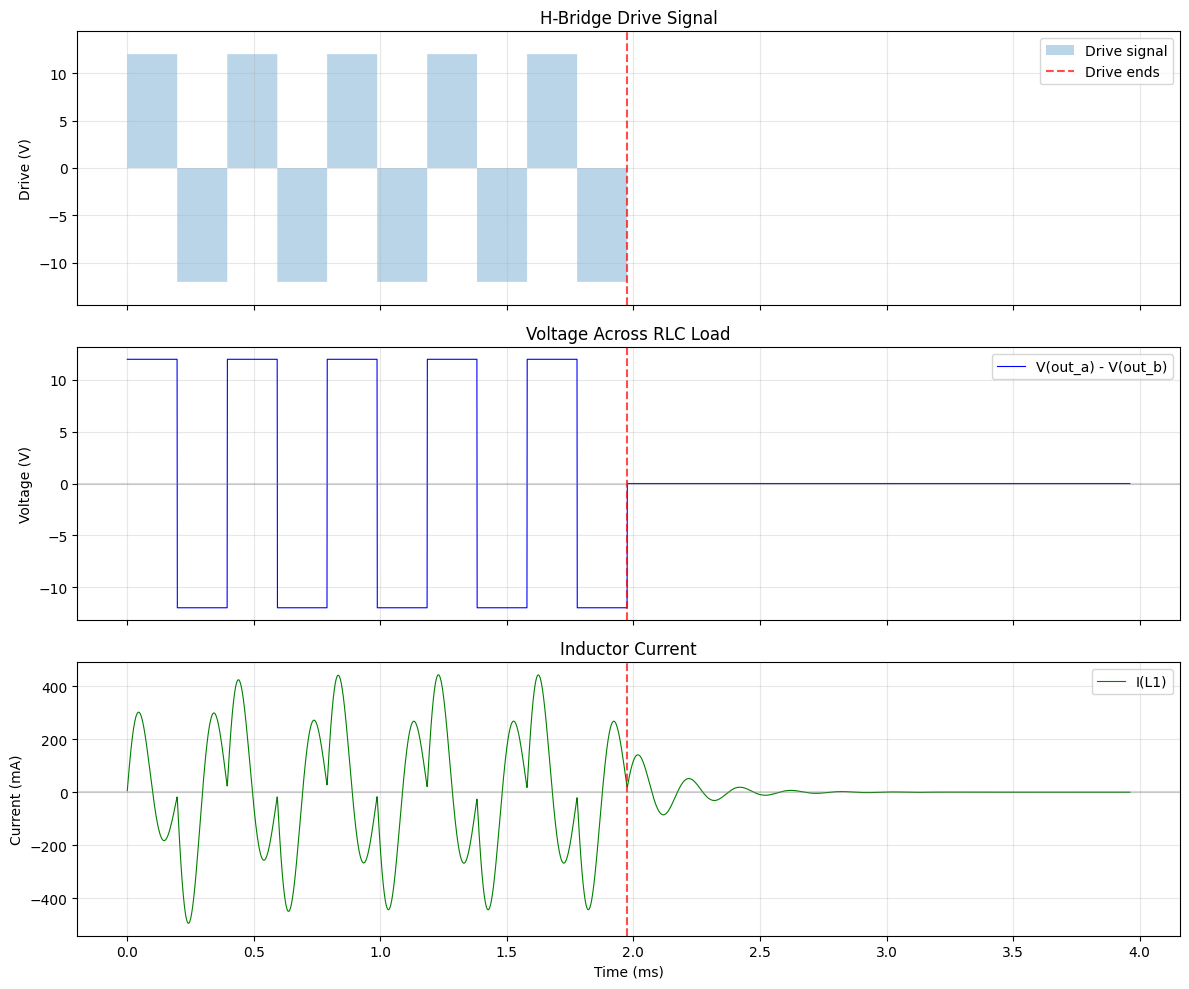

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
times_ms = times * 1e3
drive_end_ms = drive_time * 1e3

# Plot 1: H-bridge drive signal
ax1 = axes[0]
ax1.fill_between(times_ms, drive_signal * V_supply, alpha=0.3, step='mid', label='Drive signal')
ax1.axvline(x=drive_end_ms, color='red', linestyle='--', alpha=0.7, label='Drive ends')
ax1.set_ylabel('Drive (V)')
ax1.set_ylim(-V_supply * 1.2, V_supply * 1.2)
ax1.legend(loc='upper right')
ax1.set_title('H-Bridge Drive Signal')
ax1.grid(True, alpha=0.3)

# Plot 2: Voltage across RLC load
ax2 = axes[1]
ax2.plot(times_ms, v_diff, 'b-', linewidth=0.8, label='V(out_a) - V(out_b)')
ax2.axvline(x=drive_end_ms, color='red', linestyle='--', alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.set_ylabel('Voltage (V)')
ax2.legend(loc='upper right')
ax2.set_title('Voltage Across RLC Load')
ax2.grid(True, alpha=0.3)

# Plot 3: Inductor current
ax3 = axes[2]
ax3.plot(times_ms, i_inductor * 1e3, 'g-', linewidth=0.8, label='I(L1)')
ax3.axvline(x=drive_end_ms, color='red', linestyle='--', alpha=0.7)
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Current (mA)')
ax3.legend(loc='upper right')
ax3.set_title('Inductor Current')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detail: Ring-down Phase Only

Zoom in on the ring-down to see the damped oscillation clearly.

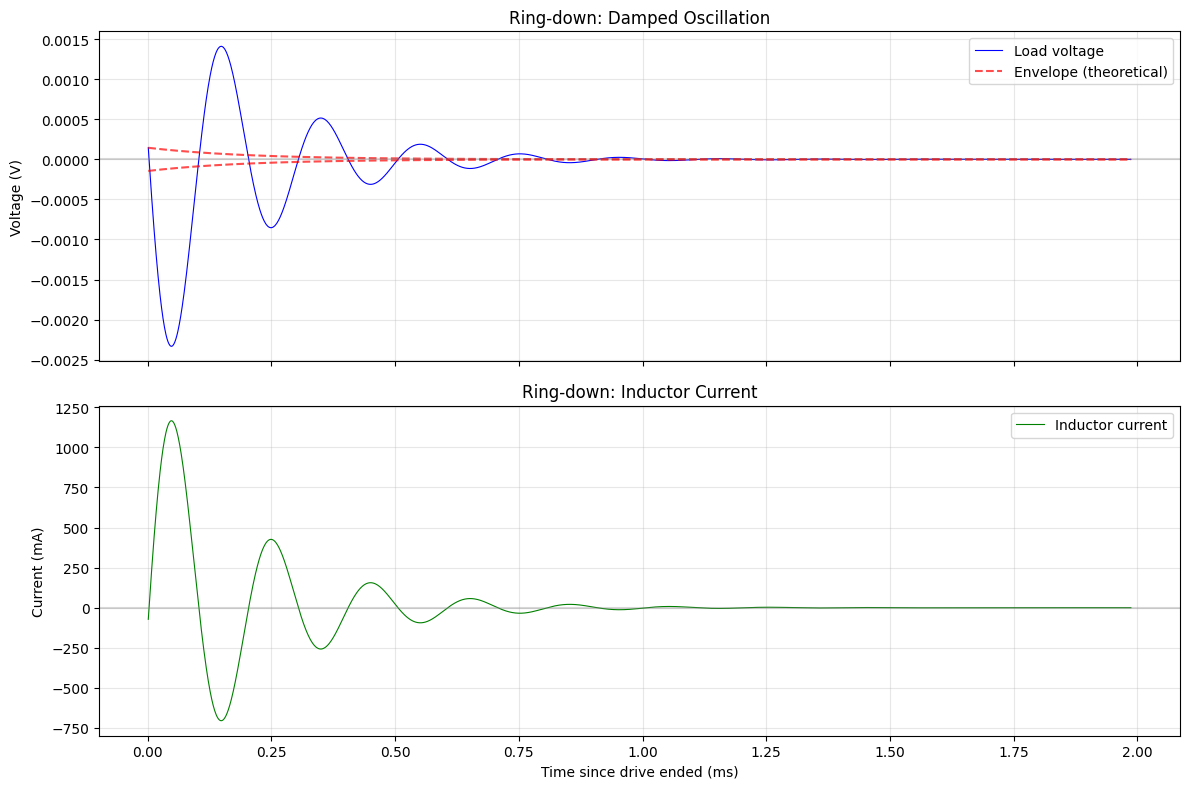

In [9]:
# Extract ring-down portion
ringdown_mask = times >= drive_time
t_ring = (times[ringdown_mask] - drive_time) * 1e3  # ms from start of ring-down
v_ring = v_diff[ringdown_mask]
i_ring = i_inductor[ringdown_mask] * 1e3  # mA

# Theoretical envelope: exp(-ζωt) where ω = 2πf0
omega_d = 2 * np.pi * f0 * np.sqrt(1 - zeta**2)  # damped frequency
alpha = zeta * 2 * np.pi * f0  # decay rate
envelope = np.abs(v_ring[0]) * np.exp(-alpha * t_ring / 1e3)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Voltage with envelope
ax1 = axes[0]
ax1.plot(t_ring, v_ring, 'b-', linewidth=0.8, label='Load voltage')
ax1.plot(t_ring, envelope, 'r--', linewidth=1.5, alpha=0.7, label='Envelope (theoretical)')
ax1.plot(t_ring, -envelope, 'r--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc='upper right')
ax1.set_title('Ring-down: Damped Oscillation')
ax1.grid(True, alpha=0.3)

# Current
ax2 = axes[1]
ax2.plot(t_ring, i_ring, 'g-', linewidth=0.8, label='Inductor current')
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.set_xlabel('Time since drive ended (ms)')
ax2.set_ylabel('Current (mA)')
ax2.legend(loc='upper right')
ax2.set_title('Ring-down: Inductor Current')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate actual decay rate
# Find peaks in the ring-down voltage
peaks = []
for i in range(1, len(v_ring) - 1):
    if v_ring[i] > v_ring[i-1] and v_ring[i] > v_ring[i+1] and v_ring[i] > 0.1:
        peaks.append((t_ring[i], v_ring[i]))

if len(peaks) >= 2:
    # Log decrement method
    peak_times = np.array([p[0] for p in peaks])
    peak_vals = np.array([p[1] for p in peaks])
    log_vals = np.log(peak_vals)
    
    # Fit line to log of peaks
    coeffs = np.polyfit(peak_times, log_vals, 1)
    measured_alpha = -coeffs[0] * 1e3  # convert from 1/ms to 1/s
    
    print(f"\nRing-down analysis:")
    print(f"  Theoretical decay rate: α = {alpha:.1f} 1/s")
    print(f"  Measured decay rate:    α = {measured_alpha:.1f} 1/s")
    print(f"  Number of peaks found: {len(peaks)}")

## Phase Portrait

Plot inductor current vs capacitor voltage to visualize the energy flow.

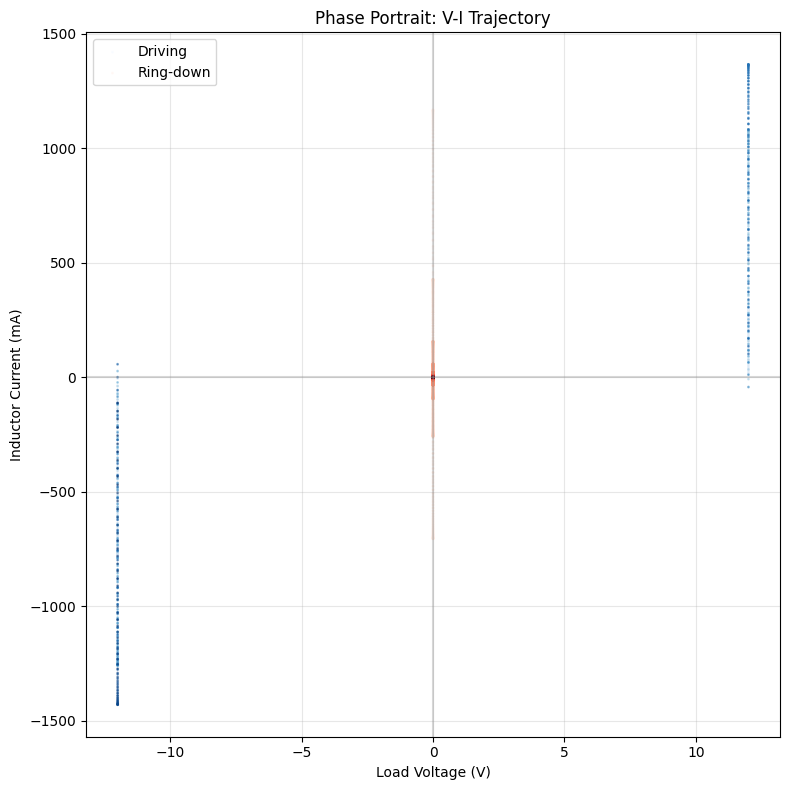


Phase portrait shows:
  - Blue: Energy being pumped in by H-bridge (expanding spiral)
  - Red: Energy dissipating in resistor (contracting spiral to origin)


In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Color by time
colors = times / times[-1]

# During drive phase
drive_mask = times < drive_time
sc1 = ax.scatter(v_diff[drive_mask], i_inductor[drive_mask] * 1e3, 
                  c=colors[drive_mask], cmap='Blues', s=1, alpha=0.5, label='Driving')

# During ring-down
sc2 = ax.scatter(v_diff[ringdown_mask], i_inductor[ringdown_mask] * 1e3,
                  c=colors[ringdown_mask], cmap='Reds', s=1, alpha=0.5, label='Ring-down')

ax.set_xlabel('Load Voltage (V)')
ax.set_ylabel('Inductor Current (mA)')
ax.set_title('Phase Portrait: V-I Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
#ax.set_aspect('equal', adjustable='datalim')
plt.tight_layout()
plt.show()

print("\nPhase portrait shows:")
print("  - Blue: Energy being pumped in by H-bridge (expanding spiral)")
print("  - Red: Energy dissipating in resistor (contracting spiral to origin)")

## Summary

This demo showed:
1. **H-bridge driving**: Square wave excitation pumps energy into the RLC
2. **Resonant behavior**: When driven at f₀, the RLC builds up amplitude
3. **Natural ring-down**: After drive stops, the RLC oscillates at its damped frequency
4. **Exponential decay**: The envelope follows e^(-αt) where α = ζω₀

The PyVibrate simulator correctly captures:
- Switch dynamics (H-bridge open/close)
- RLC resonance and damping
- Energy storage in L and C
- Resistive dissipation